# DAT500 - FinalProject, Flight Delay Prediction

Group Members:

    - Brage Solheim
    - Yohannes D. Kassaye

## Introduction

So far we have used map reduce jobs to find null values in our data, find mean and mode of each column, and fill null values with mean or mode.

We will be predicting flight delays based on data that is available prior to the day of the flight. <br>
Such data could be weather, airport, airline, origin and destination, and other factors.

## Initlization

In [2]:
import findspark
findspark.init()
findspark.find()

'/usr/local/spark'

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

In [4]:
ORIGINAL_DATA_PATH = "hdfs:///data/airline_delay_data.csv"
CLEANED_DATA_PATH = "hdfs:///data/airline_delay_data_cleaned.csv"

TEST_DATA_ORIGINAL_PATH = "/data/2015.sample.csv"
TEST_DATA_CLEANED_PATH = "/data/2015.sample.cleaned.csv"

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import pyspark
conf = pyspark.SparkConf().setAll([("spark.driver.maxResultSize", '4g'), ("spark.sql.execution.arrow.pyspark.enabled", 'true')])

In [7]:
spark = (SparkSession
            .builder
            .master("yarn") # for cluster
            # .master("local[*]") # for local testing
            .config(conf=conf)
            .appName("Flight-delay-prediction")
            .getOrCreate())

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
2022-05-01 09:49:57,989 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2022-05-01 09:50:02,399 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
2022-05-01 09:50:09,048 WARN yarn.Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [8]:
print(sc.getConf().getAll())

[('spark.ui.showConsoleProgress', 'true'), ('spark.app.id', 'application_1645016454320_0108'), ('spark.app.startTime', '1650573232844'), ('spark.driver.port', '37911'), ('spark.sql.warehouse.dir', 'file:/home/ubuntu/DAT500-FinalProject/spark/spark-warehouse'), ('spark.executor.id', 'driver'), ('spark.app.name', 'Flight-delay-prediction'), ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY_URI_BASES', 'http://namenode:8088/proxy/application_1645016454320_0108'), ('spark.driver.host', 'namenode'), ('spark.master', 'yarn'), ('spark.executorEnv.PYTHONPATH', '/usr/local/spark/python/:<CPS>{{PWD}}/pyspark.zip<CPS>{{PWD}}/py4j-0.10.9.3-src.zip'), ('spark.rdd.compress', 'True'), ('spark.serializer.objectStreamReset', '100'), ('spark.submit.pyFiles', ''), ('spark.yarn.isPython', 'true'), ('spark.submit.deployMode', 'client'), ('spark.ui.proxyBase', '/proxy/application_1645016454320_0108'), ('spark.org.apache.hadoop.yarn.server.webproxy.amfilter.AmIpFilter.param.PROXY

In [9]:
from pyspark.sql.types import StructType, StructField, StringType, DateType, DoubleType

In [10]:
features = ["FL_DATE","OP_CARRIER","OP_CARRIER_FL_NUM","ORIGIN","DEST","CRS_DEP_TIME","DEP_TIME","DEP_DELAY","TAXI_OUT","WHEELS_OFF","WHEELS_ON","TAXI_IN","CRS_ARR_TIME","ARR_TIME","ARR_DELAY","CANCELLED","DIVERTED","CRS_ELAPSED_TIME","ACTUAL_ELAPSED_TIME","AIR_TIME","DISTANCE","CARRIER_DELAY","WEATHER_DELAY","NAS_DELAY","SECURITY_DELAY","LATE_AIRCRAFT_DELAY"]
nullable=False
schema = StructType([
    StructField("FL_DATE", DateType(), nullable), StructField("OP_CARRIER", StringType(), nullable), StructField("OP_CARRIER_FL_NUM", DoubleType(), nullable),
    StructField("ORIGIN", StringType(), nullable), StructField("DEST", StringType(), nullable), StructField("CRS_DEP_TIME", DoubleType(), nullable),
    StructField("DEP_TIME", DoubleType(), nullable), StructField("DEP_DELAY", DoubleType(), nullable), StructField("TAXI_OUT", DoubleType(), nullable),
    StructField("WHEELS_OFF", DoubleType(), nullable), StructField("WHEELS_ON", DoubleType(), nullable), StructField("TAXI_IN", DoubleType(), nullable),
    StructField("CRS_ARR_TIME", DoubleType(), nullable), StructField("ARR_TIME", DoubleType(), nullable), StructField("ARR_DELAY", DoubleType(), nullable),
    StructField("CANCELLED", DoubleType(), nullable), StructField("DIVERTED", DoubleType(), nullable), StructField("CRS_ELAPSED_TIME", DoubleType(), nullable),
    StructField("ACTUAL_ELAPSED_TIME", DoubleType(), nullable), StructField("AIR_TIME", DoubleType(), nullable), StructField("DISTANCE", DoubleType(), nullable),
    StructField("CARRIER_DELAY", DoubleType(), nullable), StructField("WEATHER_DELAY", DoubleType(), nullable), StructField("NAS_DELAY", DoubleType(), nullable),
    StructField("SECURITY_DELAY", DoubleType(), nullable), StructField("LATE_AIRCRAFT_DELAY", DoubleType(), nullable)])

In [11]:
df = spark.read.csv(CLEANED_DATA_PATH, header=True, schema=schema, inferSchema=False)
df.to_pandas_on_spark().head()

2022-04-21 20:34:35,735 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:34:35,786 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:34:35,826 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,2016-09-25,AA,2622.0,EGE,DFW,800.0,749.0,-11.0,11.0,800.0,1049.0,15.0,1110.0,1104.0,-6.0,0.0,0.0,130.0,135.0,109.0,721.0,19.62,3.04,15.08,0.09,24.72
1,2016-09-25,AA,2623.0,DFW,TPA,1830.0,1915.0,45.0,20.0,1935.0,2243.0,3.0,2155.0,2246.0,51.0,0.0,0.0,145.0,151.0,128.0,929.0,0.00,0.00,6.00,0.00,45.00
2,2016-09-25,AA,2625.0,MCO,DFW,935.0,930.0,-5.0,12.0,942.0,1052.0,17.0,1124.0,1109.0,-15.0,0.0,0.0,169.0,159.0,130.0,985.0,19.62,3.04,15.08,0.09,24.72
3,2016-09-25,AA,2626.0,DFW,FLL,1429.0,1710.0,161.0,28.0,1738.0,2054.0,4.0,1814.0,2058.0,164.0,0.0,0.0,165.0,168.0,136.0,1119.0,15.00,0.00,3.00,0.00,146.00
4,2016-09-25,AA,2626.0,TUS,DFW,915.0,910.0,-5.0,10.0,920.0,1337.0,14.0,1328.0,1351.0,23.0,0.0,0.0,133.0,161.0,137.0,813.0,0.00,0.00,23.00,0.00,0.00


## Data Engineering

In [12]:
df = df.repartition(24)

In [10]:
from pyspark.sql import functions as F

As we see the order of the data is completely mixed up, so our header is in the middle of the data. <br>
We will have to find that header row, and then remove it from the data.

In [14]:
header_row = df.filter(F.col("FL_DATE").isNull())
header_row.to_pandas_on_spark()

2022-04-21 20:36:24,911 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:36:24,915 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 20:37:33,035 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,None,OP_CARRIER,NaN,ORIGIN,DEST,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


When we infer the schema, the header row is not the same type as the rest of the rows, and therefore is converted to null. <br>
And we can use this fact to filter out the header row.

In [15]:
df = df.filter((F.col("FL_DATE").isNull() & F.col("OP_CARRIER").isNotNull() & F.col("ORIGIN").isNotNull() & F.col("DEST").isNotNull()) == False)

In [16]:
header_row = df.filter(F.col("FL_DATE").isNull())
print(header_row.count())

0


Next we will encode categorical columns, because we will be using them in our model.

In [18]:
categorical_columns = [col[0] for col in df.dtypes if col[1] == "string"]
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep").fit(df) for col in categorical_columns]

pipeline = Pipeline(stages=indexers)
df_indexed = pipeline.fit(df).transform(df)
df_indexed.show(5)

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+------------------

We are also dealing with time series data, and therefore we need to encode the dates.

In [19]:
df_indexed = df_indexed.withColumn("FL_DATE", F.col("FL_DATE").cast("timestamp"))\
             .withColumn("FL_DATE_indexed", F.unix_timestamp(F.col("FL_DATE"), format="yyyy-MM-dd"))
df_indexed.show(5)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+
|            FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+------------

To make sure that our model understand the columns containing data such as Planned Departure Time, and Planned Arrival Time, we will convert them to time.

In [20]:
def Convert_time_to_string(time, date):

    time = str(int(time))
    if len(time) == 1:
        time = f"00:0{time[0]}"
    elif len(time) == 2:
        time = f"00:{time}"
    elif len(time) == 3:
        time = f"0{time[0]}:{time[1:]}"
    elif len(time) == 4:
        time = f"{time[0:2]}:{time[2:]}"
    
    if date != None:
        return f"{date} {time}"

    return time

udf_Convert_time_to_string = F.udf(Convert_time_to_string, StringType())

In [21]:
print(Convert_time_to_string(0.0, "2018-11-04"), # should be 2018-11-04 00:00
      Convert_time_to_string(4.0, "2018-11-04"), # should be  2018-11-04 00:04, because you cant have leading zeros
      Convert_time_to_string(23.0, "2018-11-04"), # should be  2018-11-04 00:23, because you cant have leading zeros
      Convert_time_to_string(808.0, "2018-11-04"), # should be  2018-11-04 08:08, because you cant have leading zeros
      Convert_time_to_string(1203.0, "2018-11-04")) # should be  2018-11-04 12:03

2018-11-04 00:00 2018-11-04 00:04 2018-11-04 00:23 2018-11-04 08:08 2018-11-04 12:03


In [23]:
df_indexed = df_indexed.withColumn("CRS_DEP_TIME_indexed", F.unix_timestamp(udf_Convert_time_to_string(F.col("CRS_DEP_TIME"), F.split(F.col("FL_DATE").cast("string"), " ").getItem(0)), format="yyyy-MM-dd HH:mm")) \
    .withColumn("CRS_ARR_TIME_indexed", F.unix_timestamp(udf_Convert_time_to_string(F.col("CRS_ARR_TIME"), F.split(F.col("FL_DATE").cast("string"), " ").getItem(0)), format="yyyy-MM-dd HH:mm"))
df_indexed.show(5, truncate=False)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+--

We will try to predict whether or not the flight is delayed, so we will create a binary column, based on either departure delay or arrival delay.

In [24]:
df_indexed = df_indexed.withColumn("Delayed", F.when((F.col("DEP_DELAY") > 0) | (F.col("ARR_DELAY") > 0), 1).otherwise(0))
df_indexed.show(5, truncate=False)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+-------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|Delayed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+-----

We also have some data regarding a flight being canceled, so we will remove any rows that have a value of 1 in the Cancelled column. <br>
given that it doesnt give us any information about the flight being delayed.

In [25]:
df_indexed.groupBy("CANCELLED").count().show()

+---------+--------+
|CANCELLED|   count|
+---------+--------+
|      0.0|23969781|
|      1.0|  355022|
+---------+--------+



In [26]:
df_indexed = df_indexed.where(F.col("CANCELLED") == 0)
df_indexed.show(5, truncate=False)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+-------+
|FL_DATE            |OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|Delayed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+-----

In [27]:
df_indexed.to_pandas_on_spark().head()

2022-04-21 21:00:11,880 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 21:00:11,884 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
2022-04-21 21:02:16,234 WARN window.WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


,FL_DATE,OP_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,OP_CARRIER_indexed,ORIGIN_indexed,DEST_indexed,FL_DATE_indexed,CRS_DEP_TIME_indexed,CRS_ARR_TIME_indexed,Delayed
0,2015-10-22,EV,3924.0,IAH,GRK,1735.0,1731.0,-4.0,12.0,1743.0,1821.0,3.0,1834.0,1824.0,-10.0,0.0,0.0,59.0,53.0,38.0,166.0,19.62,3.04,15.08,0.09,24.72,5.0,8.0,167.0,1445472000,1445535300,1445538840,0
1,2016-09-19,EV,2804.0,TXK,DFW,1027.0,1025.0,-2.0,2.0,1027.0,1102.0,16.0,1133.0,1118.0,-15.0,0.0,0.0,66.0,53.0,35.0,181.0,19.62,3.04,15.08,0.09,24.72,5.0,259.0,2.0,1474243200,1474280820,1474284780,0
2,2016-11-14,OO,7363.0,MSP,ABR,1124.0,1121.0,-3.0,11.0,1132.0,1213.0,4.0,1244.0,1217.0,-27.0,0.0,0.0,80.0,56.0,41.0,257.0,19.62,3.04,15.08,0.09,24.72,3.0,10.0,263.0,1479081600,1479122640,1479127440,0
3,2015-10-24,NK,163.0,ATL,BOS,1148.0,1146.0,-2.0,13.0,1159.0,1354.0,10.0,1418.0,1404.0,-14.0,0.0,0.0,150.0,138.0,115.0,946.0,19.62,3.04,15.08,0.09,24.72,9.0,0.0,14.0,1445644800,1445687280,1445696280,0
4,2016-11-10,DL,1560.0,TLH,ATL,700.0,656.0,-4.0,13.0,709.0,754.0,7.0,806.0,801.0,-5.0,0.0,0.0,66.0,65.0,45.0,223.0,19.62,3.04,15.08,0.09,24.72,1.0,141.0,0.0,1478736000,1478761200,1478765160,0


In [43]:
# save the data into a csv file
df_indexed.write.csv("hdfs:///data/airline_delay_data_cleaned_2.csv", mode="overwrite", header=True)

## Data Exploration and Analysis

In [36]:
CLEANED_DATA_PATH_2 = "hdfs:///data/airline_delay_data_cleaned_2.csv"

In [37]:
df_final = spark.read.csv(CLEANED_DATA_PATH_2, header=True, inferSchema=True)
df_final.show(5)

+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+------------------+--------------+------------+---------------+--------------------+--------------------+-------+
|            FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|OP_CARRIER_indexed|ORIGIN_indexed|DEST_indexed|FL_DATE_indexed|CRS_DEP_TIME_indexed|CRS_ARR_TIME_indexed|Delayed|
+-------------------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+-----

In [40]:
df_final_EDA = df_final.withColumn("year", F.year(F.col("FL_DATE"))) \
    .withColumn("month", F.month(F.col("FL_DATE"))) \
    .withColumn("day", F.dayofmonth(F.col("FL_DATE")))

### Exploring the data

Looking at delays per month <br>

In [66]:
eda_delay_per_mount = df_final_EDA.groupBy("month").sum("Delayed").toPandas()

In [75]:
eda_delay_per_year = df_final_EDA.groupBy("year").sum("Delayed").toPandas()

In [88]:
eda_delay_per_airline = df_final_EDA.groupBy("OP_CARRIER").sum("Delayed").toPandas()

In [89]:
eda_delay_per_city = df_final_EDA.groupBy("ORIGIN").sum("Delayed").toPandas()

In [69]:
import calendar
eda_delay_per_mount["month"] = eda_delay_per_mount["month"].apply(lambda x: calendar.month_abbr[x])

,month,sum(Delayed),mount
0,Dec,954545,Dec
1,Jan,873445,Jan


In [76]:
eda_delay_per_year.head()

,year,sum(Delayed)
0,2018,3195847
1,2015,2708985
2,2016,2461905
3,2017,2496422


<Figure size 1800x864 with 0 Axes>

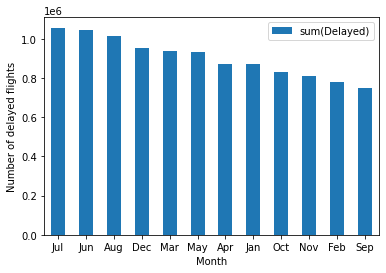

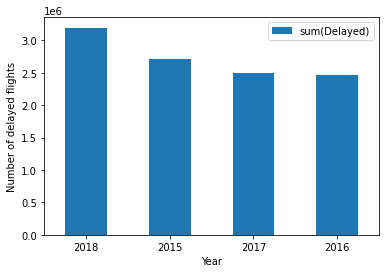

In [87]:
# plot a bar chart for the number of delayed flights per month
plt.figure(figsize=(25, 12))
eda_delay_per_mount.sort_values("sum(Delayed)", ascending=False).plot(kind="bar", x="month", y="sum(Delayed)", rot=0)
plt.xlabel("Month")
plt.ylabel("Number of delayed flights")

eda_delay_per_year.sort_values("sum(Delayed)", ascending=False).plot(kind="bar", x="year", y="sum(Delayed)", rot=0)
plt.xlabel("Year")
plt.ylabel("Number of delayed flights")

plt.show()

<Figure size 1800x720 with 0 Axes>

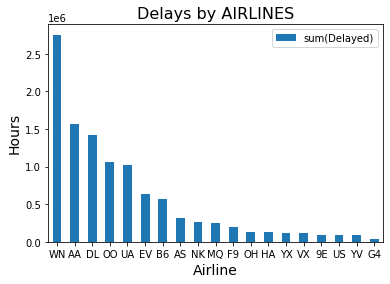

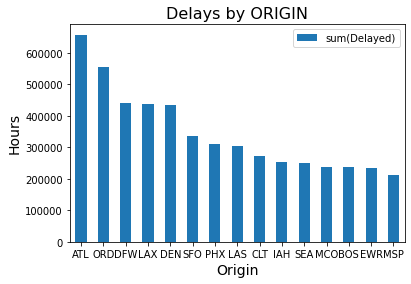

In [96]:
plt.figure(figsize=(25, 10))
eda_delay_per_airline.sort_values(by="sum(Delayed)", ascending=False).plot(kind="bar", x="OP_CARRIER", y="sum(Delayed)", rot=0)
plt.title('Delays by AIRLINES', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Hours', fontsize=14)

eda_delay_per_city.sort_values(by="sum(Delayed)", ascending=False)[:15].plot(kind="bar", x="ORIGIN", y="sum(Delayed)", rot=0)
plt.title('Delays by ORIGIN', fontsize=16)
plt.xlabel('Origin', fontsize=14)
plt.ylabel('Hours', fontsize=14)
plt.show()

In [47]:
eda_delay_distrubtion = df_final_EDA.groupBy("Delayed").count().toPandas()
eda_delay_distrubtion["Delayed"] = eda_delay_distrubtion["Delayed"].apply(lambda x: "Delayed" if x == 1 else "Not Delayed")

<Figure size 720x720 with 0 Axes>

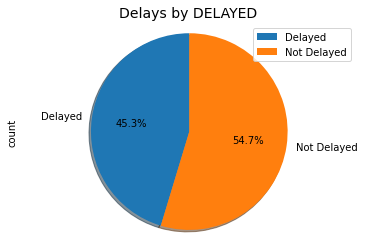

In [61]:
# pie plot for the number of delayed flights
plt.figure(figsize=(10, 10))
eda_delay_distrubtion.plot(kind="pie", y="count", labels=eda_delay_distrubtion["Delayed"], autopct="%1.1f%%", shadow=True, startangle=90)
plt.axis("equal")
plt.title('Delays by DELAYED', fontsize=14)
plt.show()

### Correlation

So far we have cleaned the data by removing and filling null values.
Now we will try to find the correlation between the our target, DEP_DELAY, and the other columns.

In [11]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [98]:
def GetCorrelationMatrix(df):
    inputcols = [col[0] for col in df.dtypes if col[1] == "double" or col[1] == "int" or col[1] == "bigint" or col[1] == "long"]
    vector_col = "features"

    assembler = VectorAssembler(inputCols=inputcols, outputCol=vector_col, handleInvalid="skip")
    df_vector = assembler.transform(df).select(vector_col)
    matrix = Correlation.corr(df_vector, "features")

    matrix_df = spark.createDataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].toArray().tolist(), inputcols).to_pandas_on_spark()
    matrix_df["feature"] = inputcols

    return matrix_df
    

In [99]:
corr_matrix = GetCorrelationMatrix(df_final_EDA)

2022-04-22 10:31:35,167 WARN correlation.PearsonCorrelation: Pearson correlation matrix contains NaN values.


In [128]:
corr_matrix = corr_matrix.set_index("feature")

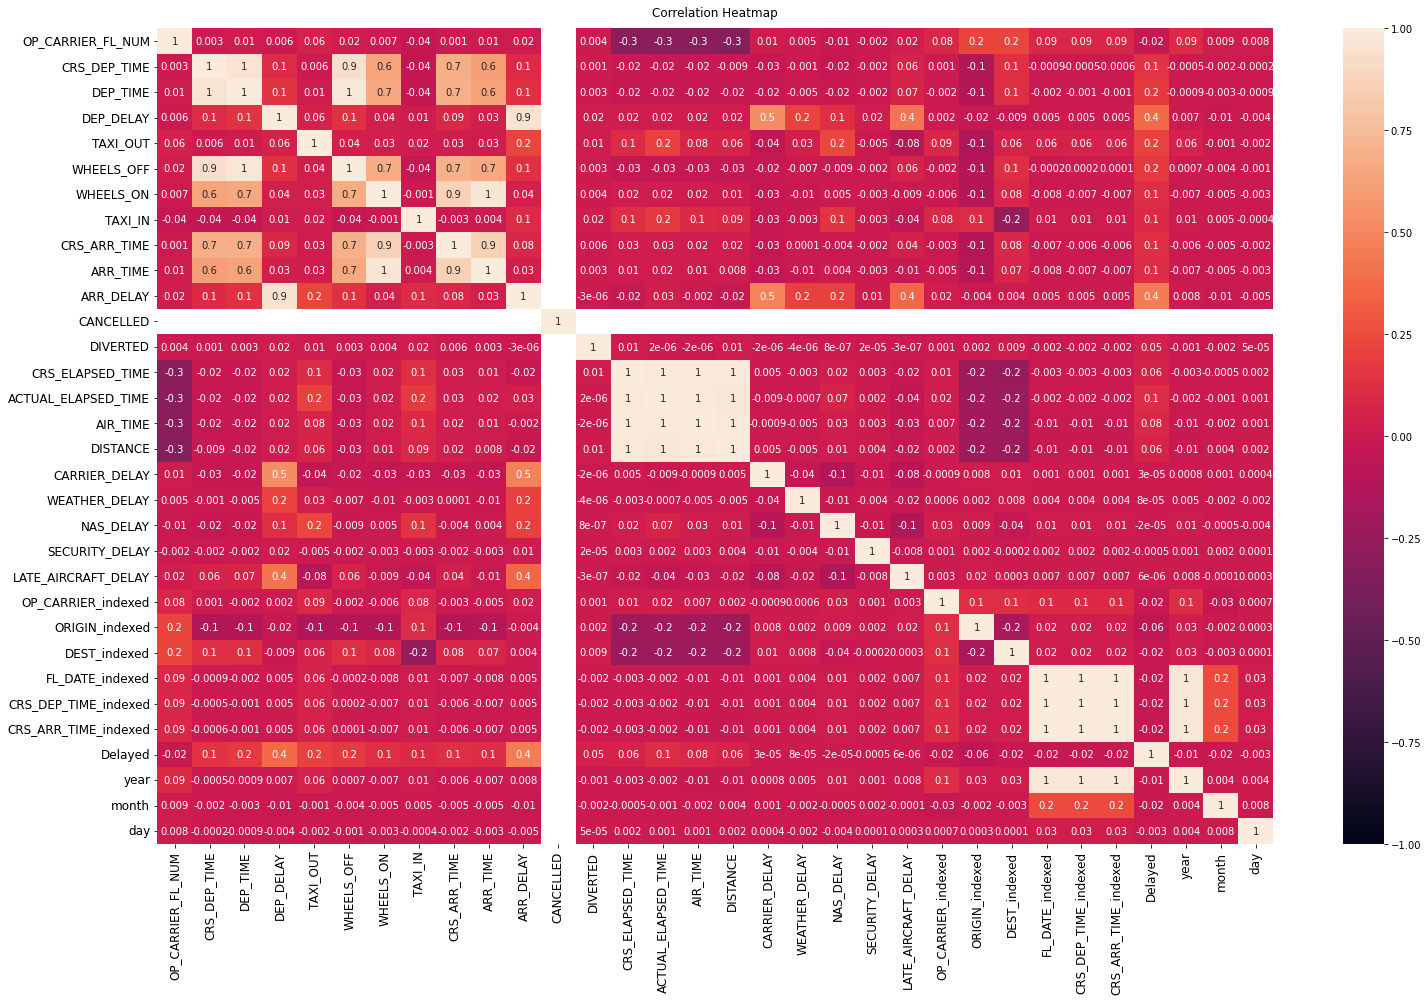

In [129]:
plt.figure(figsize=(25, 15))

heatmap = sns.heatmap(corr_matrix.values, vmin=-1, vmax=1, annot=True, fmt='.1g')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

heatmap.set_xticklabels(corr_matrix.columns, fontsize=12, rotation=90);
heatmap.set_yticklabels(corr_matrix.columns, fontsize=12, rotation=0);

In [130]:
df_final_EDA.write.csv("hdfs:///data/airline_delay_data_cleaned_EDA.csv", mode="overwrite", header=True)

----

## Predicting Delays

We will be predicting flight delays based on data that is available prior to the day of the flight. <br>
Such data could be weather, airport, airline, origin and destination, and other factors.

In [12]:
CLEANED_DATA_PATH_EDA = "hdfs:///data/airline_delay_data_cleaned_EDA.csv"

In [13]:
df_predicting = spark.read.csv(CLEANED_DATA_PATH_EDA, header=True, inferSchema=True)

Firstly we will have to remove columns containing data that is not available prior to the day of the flight. <br>

These columns are:

    - DEP_TIME - Actual Departure Time
    - DEP_DELAY - Total Delay on Departure in minutes
    - TAXI_OUT - Time between departure The time duration elapsed between departure from the origin airport gate and wheels off
    - WHEELS_OFF - The time point that the aircraft's wheels leave the ground.
    - WHEELS_ON - The time point that the aircraft'ss wheels touch on the ground.
    - TAXI_IN - The time duration elapsed between wheels-on and gate arrival at the destination airport.
    - ARR_TIME = Actual Arrival Time = ARRIVAL_TIME - SCHEDULED_ARRIVAL
    - ARR_DELAY = Total Delay on Arrival in minutes
    - DIVERTED = Aircraft landed on different airport that the one scheduled
    - AIR_TIME = The time duration between wheels_off and wheels_on time
    - DISTANCE = Distance between two airports
    - CARRIER_DELAY = Delay caused by the airline in minutes
    - NAS_DELAY = Delay caused by air system
    - SECURITY_DELAY = caused by security reasons
    - LATE_AIRCRAFT_DELAY = Delay caused by security

In [14]:
cols_to_remove = ["DEP_TIME", "DEP_DELAY", "TAXI_OUT", "WHEELS_OFF", "WHEELS_ON", "TAXI_IN", "ARR_TIME", "ARR_DELAY", "DIVERTED", "AIR_TIME", "DISTANCE", "CARRIER_DELAY", "NAS_DELAY", "SECURITY_DELAY", "LATE_AIRCRAFT_DELAY"]
df_predicting = df_predicting.drop(*cols_to_remove)

In [15]:
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

Use random split to split our data, becuase then our model wont rely on any outlier years, and it can focus on the months

In [16]:
inputcols = [col[0] for col in df_predicting.dtypes if (col[1] == "double" or col[1] == "int" or col[1] == "bigint" or col[1] == "long") and col[0] != "Delayed"]
vector_col = "features"

assembler = VectorAssembler(inputCols=inputcols, outputCol=vector_col, handleInvalid="skip")
df_vector = assembler.transform(df_predicting).select([vector_col, "Delayed"])

In [17]:
(train, test) = df_vector.randomSplit([0.7, 0.3], seed=12345)

### Logistic Regression

In [15]:
lr = LogisticRegression(featuresCol="features", labelCol="Delayed", maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrmodel = lr.fit(train)

lr_pred = lrmodel.transform(test)
lr_pred.show(3)

2022-04-22 13:20:34,118 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------+--------------------+--------------------+----------+
|            features|Delayed|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[1.0,600.0,711.0,...|      0|[0.18769353995407...|[0.54678611375984...|       0.0|
|[1.0,700.0,805.0,...|      0|[0.18769353995407...|[0.54678611375984...|       0.0|
|[1.0,700.0,805.0,...|      0|[0.18769353995407...|[0.54678611375984...|       0.0|
+--------------------+-------+--------------------+--------------------+----------+
only showing top 3 rows



In [16]:
avaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction")
acc = avaluator.evaluate(lr_pred)
print("Accuracy:", acc)

Accuracy: 0.38662430342736637


### Decision Tree classifier

In [18]:
dt = DecisionTreeClassifier(featuresCol="features", labelCol="Delayed", maxDepth=5)
dtmodel = dt.fit(train)

dt_pred = dtmodel.transform(test)
dt_pred.show(3)

2022-05-01 09:55:27,581 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------+--------------------+--------------------+----------+
|            features|Delayed|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[1.0,600.0,711.0,...|      0|[3843752.0,130317...|[0.74680551980065...|       0.0|
|[1.0,700.0,805.0,...|      0| [708525.0,284108.0]|[0.71378344262179...|       0.0|
|[1.0,700.0,805.0,...|      0| [708525.0,284108.0]|[0.71378344262179...|       0.0|
+--------------------+-------+--------------------+--------------------+----------+
only showing top 3 rows



In [19]:
dt_eval = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction")
acc = dt_eval.evaluate(dt_pred)
print("Accuracy:", acc)

Accuracy: 0.7228697129224704


In [20]:
dt_evaluator_binary = BinaryClassificationEvaluator(labelCol="Delayed", rawPredictionCol="prediction")
dt_acc_binary = dt_evaluator_binary.evaluate(dt_pred)
print("Accuracy:", dt_acc_binary)

Accuracy: 0.7176673807378716


### Random Forrest Classifier

In [21]:
rfc = RandomForestClassifier(featuresCol="features", labelCol="Delayed")
rfc = rfc.fit(train)

pred = rfc.transform(test)
pred.show(3) 

+--------------------+-------+--------------------+--------------------+----------+
|            features|Delayed|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[1.0,600.0,711.0,...|      0|[14.1086361488801...|[0.70543180744400...|       0.0|
|[1.0,700.0,805.0,...|      0|[13.9422051245022...|[0.69711025622511...|       0.0|
|[1.0,700.0,805.0,...|      0|[14.1891954553764...|[0.70945977276882...|       0.0|
+--------------------+-------+--------------------+--------------------+----------+
only showing top 3 rows



In [22]:
avaluator = MulticlassClassificationEvaluator(labelCol="Delayed", predictionCol="prediction")
acc = avaluator.evaluate(pred)
print("Accuracy:", acc)

Accuracy: 0.7049789691773587
